<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/BiGRU/emo_emb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch BiGRU https://github.com/ppkgtmm/emotion.git emotion

In [3]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, emb
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [4]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Choice('output_dim',[16, 32, 64, 128, 256])
hp.Choice('optimizer', ['adam', 'nadam', 'amsgrad'])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
seed = 1234

In [5]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
12881,im just feeling particularly obnoxious tonight,anger
11880,i was feeling strong and dodging international...,joy
10742,i feel welcomed and loved,joy
1077,i feel incredibly idiotic but i was also embar...,sadness
5362,i began making dinner feeling good that i had ...,joy


In [6]:
train.shape, test.shape

((17000, 2), (3000, 2))

In [7]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [8]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [9]:
print(train['target'].unique(), train['target'].unique())

['fear' 'joy' 'sadness' 'anger' 'surprise' 'love'] ['fear' 'joy' 'sadness' 'anger' 'surprise' 'love']


In [10]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [11]:
tuner = BayesianOptimization( emb.build_emb,
                              'val_accuracy',
                              12,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/emb_B32',
                            )

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/__ed__/emb_B32/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 16)           240000    
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 28806     
Total params: 268,806
Trainable params: 268,806
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/__ed__/emb_B32/tuner0.json


In [ ]:
history = tuner.search(sequence_train, target_train,
             validation_split=0.1,
             epochs=3)

Trial 12 Complete [00h 02m 59s]
val_accuracy: 0.8605882525444031

Best val_accuracy So Far: 0.8632352948188782
Total elapsed time: 00h 25m 20s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
output_dim (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'nadam', 'amsgrad'], 'ordered': False}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}


In [ ]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/emb_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: adam
max_len: 300
num_words: 15000
Score: 0.8632352948188782
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
max_len: 300
num_words: 15000
Score: 0.8623529374599457
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
max_len: 300
num_words: 15000
Score: 0.8608823716640472


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 460806    
Total params: 4,300,806
Trainable params: 4,300,806
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = emb.build_emb(tuner.get_best_hyperparameters(num_trials=1)[0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          3840000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 76800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 460806    
Total params: 4,300,806
Trainable params: 4,300,806
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cb = utils.get_callbacks('emb.h5')

In [ ]:
history = model.fit(
    sequence_train, target_train,
    validation_split=0.1,
    epochs=15,
    callbacks=cb
)

Epoch 1/15
479/479 [==============================] - 29s 62ms/step - loss: 1.2020 - accuracy: 0.5704 - precision_1: 0.8637 - recall_1: 0.2746 - val_loss: 0.6719 - val_accuracy: 0.8082 - val_precision_1: 0.9031 - val_recall_1: 0.6471

Epoch 00001: val_accuracy improved from -inf to 0.80824, saving model to emb.h5
Epoch 2/15
479/479 [==============================] - 29s 60ms/step - loss: 0.2999 - accuracy: 0.9235 - precision_1: 0.9496 - recall_1: 0.8737 - val_loss: 0.4386 - val_accuracy: 0.8618 - val_precision_1: 0.8959 - val_recall_1: 0.8100

Epoch 00002: val_accuracy improved from 0.80824 to 0.86176, saving model to emb.h5
Epoch 3/15
479/479 [==============================] - 29s 60ms/step - loss: 0.0893 - accuracy: 0.9801 - precision_1: 0.9833 - recall_1: 0.9759 - val_loss: 0.4058 - val_accuracy: 0.8571 - val_precision_1: 0.8797 - val_recall_1: 0.8347

Epoch 00003: val_accuracy did not improve from 0.86176
Epoch 4/15
479/479 [==============================] - 29s 60ms/step - loss: 0

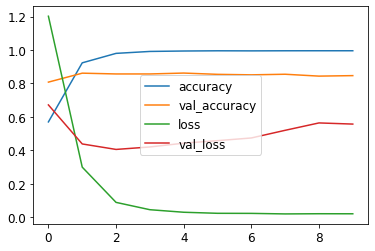

In [ ]:
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
pd.DataFrame(history.history)[metr].plot()

In [15]:
from keras.models import load_model

94/94 [==============================] - 0s 3ms/step
Accuracy:	84.5%


              precision    recall  f1-score   support

       anger       0.85      0.84      0.84       406
        fear       0.85      0.71      0.77       356
         joy       0.85      0.90      0.87      1014
        love       0.74      0.71      0.72       246
     sadness       0.88      0.91      0.89       870
    surprise       0.73      0.57      0.64       108

    accuracy                           0.84      3000
   macro avg       0.82      0.77      0.79      3000
weighted avg       0.84      0.84      0.84      3000



<Figure size 432x288 with 0 Axes>

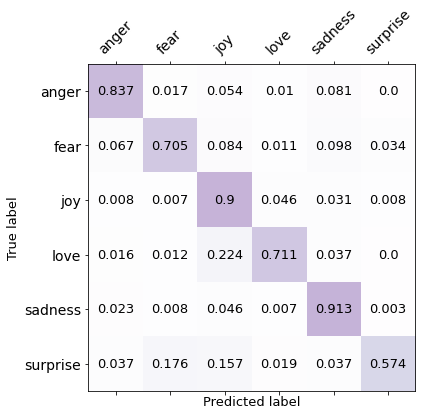

In [16]:
utils.model_evaluate(load_model('/content/drive/MyDrive/__ed__/emb_B32/best.h5'), sequence_test, target_test, 32)

In [12]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 460806    
Total params: 4,300,806
Trainable params: 4,300,806
Non-trainable params: 0
_________________________________________________________________


94/94 [==============================] - 0s 3ms/step
Accuracy:	84.1%


              precision    recall  f1-score   support

       anger       0.87      0.78      0.82       406
        fear       0.85      0.72      0.78       356
         joy       0.82      0.93      0.87      1014
        love       0.84      0.60      0.70       246
     sadness       0.87      0.92      0.89       870
    surprise       0.76      0.55      0.63       108

    accuracy                           0.84      3000
   macro avg       0.83      0.75      0.78      3000
weighted avg       0.84      0.84      0.84      3000



<Figure size 432x288 with 0 Axes>

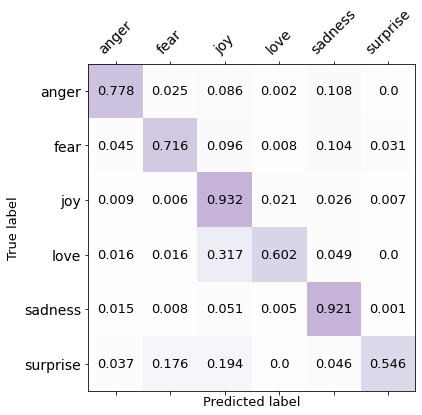

In [17]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [ ]:
# utils.dump(tokenizer,'/content/drive/MyDrive/__ed__/emb_B32/tokenizer.pickle')
# utils.dump(history.history,'/content/drive/MyDrive/__ed__/emb_B32/history.pickle')

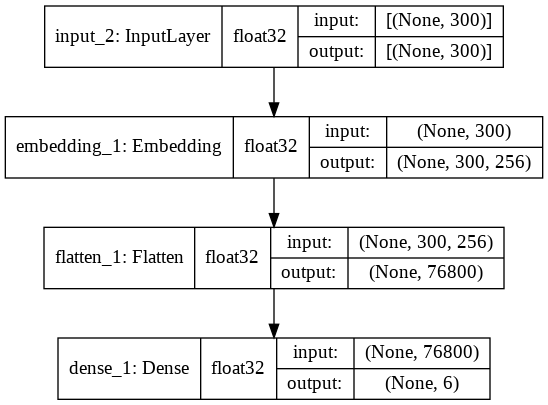

In [ ]:
from keras.utils import plot_model
plot_model(
    model,
    to_file='/content/drive/MyDrive/__ed__/emb_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )